In [12]:
from collections import defaultdict

import matplotlib.pyplot as plt
# 常用包
import numpy as np
import pandas as pd
import seaborn as sns
# 导入torch
import torch
import torch.nn.functional as F
from pylab import rcParams
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
# 导入transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [13]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device的用处是作为Tensor或者Model被分配到的位置

device

device(type='cpu')

In [14]:
torch.cuda.is_available()

False

In [4]:
with open('train_dataset_v.tsv', 'r', encoding='utf-8') as handler:
    lines = handler.read().split('\n')[1:-1]

    data = list()
    for line in tqdm(lines):
        sp = line.split('\t')
        if len(sp) != 4:
            print("ERROR:", sp)
            continue
        data.append(sp)

train = pd.DataFrame(data)
train.columns = ['id', 'content', 'character', 'emotions']

test = pd.read_csv('test_dataset.tsv', sep='\t')
submit = pd.read_csv('submit_example.tsv', sep='\t')
train = train[train['emotions'] != '']

100%|██████████| 6910/6910 [00:00<00:00, 255878.95it/s]


In [5]:
#文本拼接
train['text'] = train[ 'content'].astype(str)  +'角色: ' + train['character'].astype(str)
test['text'] = test['content'].astype(str) + ' 角色: ' + test['character'].astype(str)

In [6]:
# 标签转换
train['emotions'] = train['emotions'].apply(lambda x: [int(_i) for _i in x.split(',')])

train[['love', 'joy', 'fright', 'anger', 'fear', 'sorrow']] = train['emotions'].values.tolist() #无索引筛选
test[['love', 'joy', 'fright', 'anger', 'fear', 'sorrow']] =[0,0,0,0,0,0]
train['joy'].value_counts()
#数据集出现次数

0    5982
1     168
2      72
3      21
Name: joy, dtype: int64

In [7]:
train.head()

,id,content,character,emotions,text,love,joy,fright,anger,fear,sorrow
0,1171_0001_A_1,天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。,o2,"[0, 0, 0, 0, 0, 0]",天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。角色: o2,0,0,0,0,0,0
1,1171_0001_A_2,天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。,c1,"[0, 0, 0, 0, 0, 0]",天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。角色: c1,0,0,0,0,0,0
2,1171_0001_A_3,o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。,o2,"[0, 0, 0, 0, 0, 0]",o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。角色: o2,0,0,0,0,0,0
3,1171_0001_A_4,o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。,c1,"[0, 0, 0, 0, 0, 0]",o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。角色: c1,0,0,0,0,0,0
4,1171_0001_A_5,o2停下来接过c1手里的行李：你妈妈交待我了，等领了军装一定要照张相寄回去，让街坊邻居都知道...,o2,"[0, 0, 0, 0, 0, 0]",o2停下来接过c1手里的行李：你妈妈交待我了，等领了军装一定要照张相寄回去，让街坊邻居都知道...,0,0,0,0,0,0


In [39]:
#tokenizer
PRE_TRAINED_MODEL_NAME = 'hfl/chinese-roberta-wwm-ext'

# 加载分词器
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

#选取文本最大长度
from transformers import logging
logging.set_verbosity_warning()

token_lens = []
for txt in tqdm(train.text):
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

100%|██████████| 6243/6243 [00:05<00:00, 1153.49it/s]


D:\3xia\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


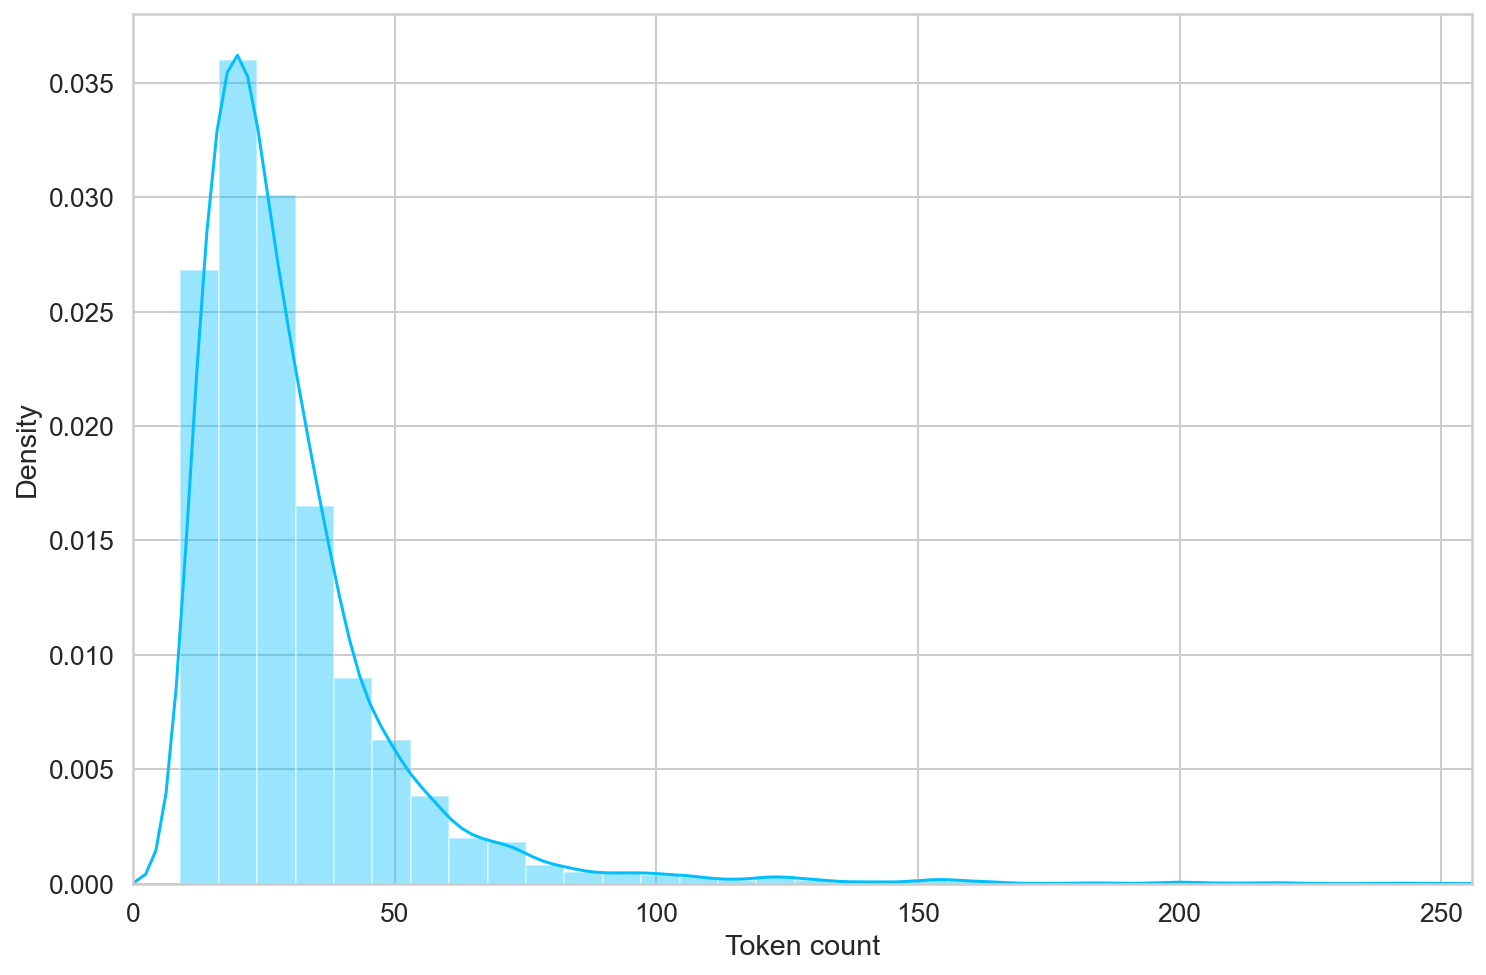

In [34]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [35]:
pd.Series(token_lens).describe()

count    6243.000000
mean       29.867532
std        20.157214
min         9.000000
25%        18.000000
50%        25.000000
75%        35.000000
max       376.000000
dtype: float64

In [36]:
MAX_LEN=128 # 选定128

# 构建学术论文数据集
target_cols=['love', 'joy', 'fright', 'anger', 'fear', 'sorrow']

In [19]:
#自定义数据集
class RoleDataset(Dataset):
    def __init__(self,texts,labels,tokenizer,max_len):
        self.texts=texts
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,item):
        """
        item 为数据索引，迭代取第item条数据
        """
        text=str(self.texts[item])
        label=self.labels[item]
        
        #分词器
        encoding=self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,# 句子开头和分隔加cls sep  [cls] + text + [sep]
            max_length=self.max_len,
            return_token_type_ids=True,# 分句ids  
            pad_to_max_length=True,
            return_attention_mask=True,# 注意力编码  
            return_tensors='pt',# pytorch类型
        )
        
#         print(encoding['input_ids'])
        sample = {
            'texts': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
            
            #input_ids：是单词在词典中的编码
            #attention_mask：指定对哪些词进行self-Attention操作
        }
        for label_col in target_cols:
            sample[label_col] = torch.tensor(label[label_col], dtype=torch.float)
        return sample
        

In [20]:
#划分数据集并创建生成器
df_train, df_val = train_test_split(train, test_size=0.1, random_state=RANDOM_SEED)
#随机划分数据集

def create_data_loader(df,tokenizer,max_len,batch_size):
    ds=RoleDataset(
        texts=df['text'].values,
        labels=df[target_cols].to_dict('records'),#DataFrame转换为字典(dict),‘records':{column -> value}
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size
#         num_workers=4 # windows多线程
    )
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

# test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
data = next(iter(train_data_loader))
data.keys()

C:\Users\PCL\AppData\Roaming\Python\Python39\site-packages\transformers\tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['texts', 'input_ids', 'attention_mask', 'love', 'joy', 'fright', 'anger', 'fear', 'sorrow'])

In [21]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['love'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


In [22]:
# 加载预训练模型
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

#定义分类模型
class EmotionClassifier(nn.Module):
    def __init__(self, n_classes):
        super(EmotionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.out_love = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out_joy = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out_fright = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out_anger = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out_fear = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out_sorrow = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    #修改配置
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict = False
        )
        love = self.out_love(pooled_output)
        joy = self.out_joy(pooled_output)
        fright = self.out_fright(pooled_output)
        anger = self.out_anger(pooled_output)
        fear = self.out_fear(pooled_output)
        sorrow = self.out_sorrow(pooled_output)
        return {
            'love': love, 'joy': joy, 'fright': fright,
            'anger': anger, 'fear': fear, 'sorrow': sorrow,
        }
# class_names=train.love.unique()
class_names=[1]
model = EmotionClassifier(len(class_names))
model = model.to(device)
#将所有最开始读取数据时的tensor变量copy一份到device所指定的cpu上去，之后的运算都在那里上进行。

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.bias', 'cls.pred

In [23]:
EPOCHS = 1 # 训练轮数

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)#定义优化器:反向传播过程中使用
total_steps = len(train_data_loader) * EPOCHS

# 设计 learning rate scheduler  学习率预热
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,#热身阶段的步数
  num_training_steps=total_steps
)

#均方损失函数
loss_fn = nn.MSELoss().to(device)

#模型训练
def train_epoch(
  model, 
  data_loader, 
  criterion, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for sample in tqdm(data_loader):
        input_ids = sample["input_ids"].to(device)
        attention_mask = sample["attention_mask"].to(device)
        outputs = model(  #用input_ids,attention_mask计算输出
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        loss_love = criterion(outputs['love'], sample['love'].to(device))#计算损失
        loss_joy = criterion(outputs['joy'], sample['joy'].to(device))
        loss_fright = criterion(outputs['fright'], sample['fright'].to(device))
        loss_anger = criterion(outputs['anger'], sample['anger'].to(device))
        loss_fear = criterion(outputs['fear'], sample['fear'].to(device))
        loss_sorrow = criterion(outputs['sorrow'], sample['sorrow'].to(device))
        loss = loss_love + loss_joy + loss_fright + loss_anger + loss_fear + loss_sorrow
        
        losses.append(loss.item()) # 保存损失值中间状态
        loss.backward() # 反向传播损失值,计算损失对于各个参数的梯度
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()# 更新参数
        scheduler.step()
        optimizer.zero_grad()# 清空梯度
#     return correct_predictions.double() / (n_examples*6), np.mean(losses)
    return np.mean(losses)

#验证函数：
def eval_model(model, data_loader, criterion, device, n_examples):
    model = model.eval() # 验证预测模式

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for sample in tqdm(data_loader):
            input_ids = sample["input_ids"].to(device)
            attention_mask = sample["attention_mask"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            loss_love = criterion(outputs['love'], sample['love'].to(device))
            loss_joy = criterion(outputs['joy'], sample['joy'].to(device))
            loss_fright = criterion(outputs['fright'], sample['fright'].to(device))
            loss_anger = criterion(outputs['anger'], sample['anger'].to(device))
            loss_fear = criterion(outputs['fear'], sample['fear'].to(device))
            loss_sorrow = criterion(outputs['sorrow'], sample['sorrow'].to(device))
            loss = loss_love + loss_joy + loss_fright + loss_anger + loss_fear + loss_sorrow

            losses.append(loss.item())
    return  np.mean(losses)

#训练
history = defaultdict(list) # 记录10轮loss和acc
best_loss = float('inf')# 正无穷

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss}')

    val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} ')
    print()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    if val_loss < best_loss:
        torch.save(model.state_dict(), 'bestmodelstate.bin')

C:\Users\PCL\AppData\Roaming\Python\Python39\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1
----------


  0%|          | 0/352 [00:00<?, ?it/s]C:\Users\PCL\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 351/352 [2:20:38<00:16, 16.21s/it]    C:\Users\PCL\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 352/352 [2:20:41<00:00, 23.98s/it]


Train loss 1.235310478368774


 98%|█████████▊| 39/40 [03:17<00:05,  5.09s/it]C:\Users\PCL\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 40/40 [03:18<00:00,  4.96s/it]


Val   loss 1.2054554039612413 



In [24]:
#模型预测
test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)
#Train loss=1.4642967580668647
#Val loss=1.5290106015036935
def predict(model):
    val_loss = 0
    test_pred = defaultdict(list)
    model.eval()
    for step, batch in tqdm(enumerate(test_data_loader)):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)

        with torch.no_grad():#上下文管理器,这样可以执行计算，但该计算不会在反向传播中被记录。
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
            for col in target_cols:
                test_pred[col].append(logits[col].to('cpu').numpy())
    preds = {}
    for col in target_cols:
        print(len(np.concatenate(test_pred[col])))
        preds[col] = (np.concatenate(test_pred[col]))#np.concatenate(),连接,能够一次完成多个数组的拼接
    return preds

submit = pd.read_csv('submit_example.tsv', sep='\t')

best_model = EmotionClassifier(len(class_names))
path = f'bestmodelstate.bin'
best_model.load_state_dict(torch.load(path))
best_model.to(device)
test_pred = predict(best_model)

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]C:\Users\PCL\AppData\Roaming\Python\Python39\site-packages\transformers\tokenization_utils_base.py:2302: FutureWarning: The `pa

21376
21376
21376
21376
21376
21376


In [37]:
label_preds = []
for col in target_cols:
    preds = test_pred[col]
    label_preds.append(preds.flatten())
sub = submit.copy()
sub['emotion'] = np.stack(label_preds, axis=1).tolist() #np.stack() 沿着新轴连接数组的序列
sub['emotion'] = sub['emotion'].apply(lambda x: ','.join([str(i) for i in x]))
sub.head()

,id,emotion
0,34170_0002_A_12,"0.0689864307641983,0.065360426902771,0.1073034..."
1,34170_0002_A_14,"0.06772089004516602,0.0612887479364872,0.10759..."
2,34170_0003_A_16,"0.05487876757979393,0.06384250521659851,0.1149..."
3,34170_0003_A_17,"0.0734172910451889,0.06610366702079773,0.10575..."
4,34170_0003_A_18,"0.06891673803329468,0.07294225692749023,0.1140..."


In [40]:
sub.to_csv(f'baseline.tsv', sep='\t', index=False)